## Welcome to the boot camp Python class!
The focus of the class is on applying coding tools to important problems in finance.
* This class will be hard for many of you -- this is intentional
* There are no tests: If you push yourself, you will learn a lot
* The way to learn the code is to run the code and understand what it does
* You won't get it the first time you see it -- you need to analyze and run the code

We are going to cover:
* Class 1: Option pricing and structuring code
* Class 2: Black-Scholes and simulations
* Class 3: Regressions and machine learning

## What is an option?
* An option gives the holder the right but not the obligation to buy (a call) or sell (a put) a security in the future
* For example, you may have the right to buy Bitcoin at 35,000 after three months
* If the value of Bitcoin is above 35,000 you would choose to exercise the option
* If not, then the option expires worthless, but you don't have to buy at 35,000 if it's trading at 25,000
* The revolutionary result in this area was the Black-Scholes-Merton (1973) option pricing formula, which we'll see next class
* Today, we are going to do option pricing using binomial trees

## Say the security follows this price path
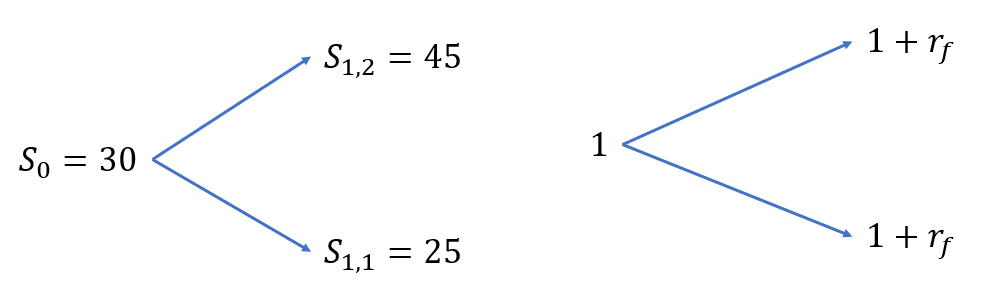
* We have a call option struck at $K=35$ on a stock with price $S_0=30$
* Say that the risk-free return over this time period is 2%, i.e., $1 \to 1.02$
* What is the option price $P_0$?

We can solve for the price as follows:
* If the high state happens at time 1, then the option will be worth $P_{1,2} = \max(0,S_{1,2}-K) = 10$
    * The $\max(\cdot)$ is there because you don't have to exercise -- do it only if profitable
* If the low state happens at time 1, then you get $P_{1,1} = \max(0,S_{1,1}-K)=0$
* To price the option, we can figure out the *replicating portfolio* using the stock price and the bond
* We would like to find a stock position $\Delta$ and a bond position $X$ so that
$$
\begin{aligned}
\Delta S_{1,2} + X(1+r_f) &= P_{1,2} \\
\Delta S_{1,1} + X(1+r_f) &= P_{1,1}
\end{aligned}
$$

A little bit of algebra reveals that
$$
\begin{aligned}
\Delta &= \frac{P_{1,2} - P_{1,1}}{S_{1,2}-S_{1,1}} \\
X &= \frac{1}{1+r_f} \times \frac{P_{1,1}S_{1,2} - P_{1,2}S_{1,1}}{S_{1,2}-S_{1,1}}
\end{aligned}
$$

Note that a replicating portfolio of $\Delta$ stock and $X$ cash will have the same payout as the option at time 1

* Because the replicating portfolio has the same payout as the option, by *no arbitrage* the option and the replicating portfolio should have the same price
\begin{equation}
    P_0 = \Delta \times S_0 + X \tag{$\dagger$}
\end{equation}
    * Everything on the right-hand of $(\dagger)$ side is known
* Surprisingly, we didn't need to know the probabilities of the up or down state
* Congrats! You now know how to price options! (Sort of)
* Let's code this up in Python and see how much our option is worth

## Using functions
* Functions allow you to include a logical unit of computation into an easy-to-use structure
* Functions have parameters that are passed in which tell them what they should do
* It is extremely good coding practice to combine smallish logical units of computation into functions

In [1]:
def price_one_period(s0,s1,p1,rf):
    '''
    s0 -- the tie 0 stock price
    s1 -- the vector of time 1 stock prices
    p1 -- the vector of time 1 option prices
    rf -- the risk-free rate
    '''
    
    ## first compute the delta and the cash position
    ## (note arrays in Python start at 0)
    delta = (p1[1]-p1[0])/(s1[1]-s1[0])
    XX = 1/(1+rf)*(p1[0]*s1[1]-p1[1]*s1[0])/(s1[1]-s1[0])
    p0 = delta * s0 + XX
    
    return p0

In [3]:
## price option, using Pandas series as array structure
import pandas as pd ## enormously useful for data and plotting (more soon)
import numpy as np
kk = 35
rf = 0.02
s1 = np.array([45,25]) ## default indexes are 0 and 1
print(s1)
p1 = np.maximum(s1-kk,0) ## this captures the logic of the option
print(p1)
## now price the option
price_one_period(s0=30,s1=s1,p1=p1,rf=rf)

[45 25]
[10  0]


2.745098039215687

## Another way of looking at the valuation equation
With a little algebra, the valuation equation from $(\dagger)$ can be re-written as
$$
    P_0 = \frac{1}{1+r_f} \left[ Q P_{1,2} + (1-Q) P_{1,1} \right]
$$
where the probability of the *up* state at time 1 is
$$
    Q = \frac{S_0 (1+r_f) - S_1}{S_2-S_1}
$$
* The $Q$'s are called *risk-neutral probabilities* and depend on $r_f$ and the stock prices, not the option prices
* The price of the option is the *discounted* value of its *expected* time-1 payout
$$
    P_0 = \frac{1}{1+r_f} E_0^Q[P_1]
$$
where $P_1$ is the time $1$ option payout or price
* At time 0 we don't know which state will happen so need to take an expectation

## Checking that things work

* Now probabilities have enterred the picture, but these are *risk-neutral* probabilities
    * They are made up to generate the correct option price when you discount the payouts at the risk-free rate
    * We still do not need to know the *actual* real-world state probabilities
* We now modify the code to compute options prices using the expectations method
* Note that the no-arbitrage and expectations methods are *exactly the same*
    * The expectations method is just an algebraic transformation of the no-arbitrage method that allows for a convenient intepretation
* We use an `assert` statement to make sure the answers match
    * It is *very good* practice to ensure that things make sense throughout your code

In [6]:
def price_one_period(s0,s1,p1,rf,silent=False):
    '''
    s0 -- the tie 0 stock price
    s1 -- the vector of time 1 stock prices
    p1 -- the vector of time 1 option prices
    rf -- the risk-free rate
    silent -- flag to see if we function should be silent
    '''
    ## first compute the delta and the cash position (note arrays in Python start at 0)
    delta = (p1[1]-p1[0])/(s1[1]-s1[0])
    XX = 1/(1+rf)*(p1[0]*s1[1]-p1[1]*s1[0])/(s1[1]-s1[0])
    p0 = delta * s0 + XX
    
    ## double check using the risk-neutral approach
    QQ = (s0*(1+rf)-s1[0])/(s1[1]-s1[0])
    p0_other = 1/(1+rf)*(QQ*p1[1]+(1-QQ)*p1[0])
   
    ## a sanity check -- the two methods should give the same result
    ## (why the 1e-15 business?)
    assert np.abs(p0 - p0_other) < 1e-15
    
    if not silent:
        print(f'Option prices: method 1 = {p0:.4f}  method 2 = {p0_other:.4f}')
    
    return p0

price_one_period(s0=30,s1=s1,p1=p1,rf=rf)

Option prices: method 1 = 2.7451  method 2 = 2.7451


2.745098039215687

## Taking stock
* So far we see how to price a one-period option if we know what the time 1 stock prices can be in the high and low state
* Conveniently, we don't need to know the probabilities of either state
* The problem is that a probabilistic model that allows for only two possible stock price outcomes is not a very good model
* Stocks can have many different future outcomes

* Here is a histogram of weekly stock returns for MSFT
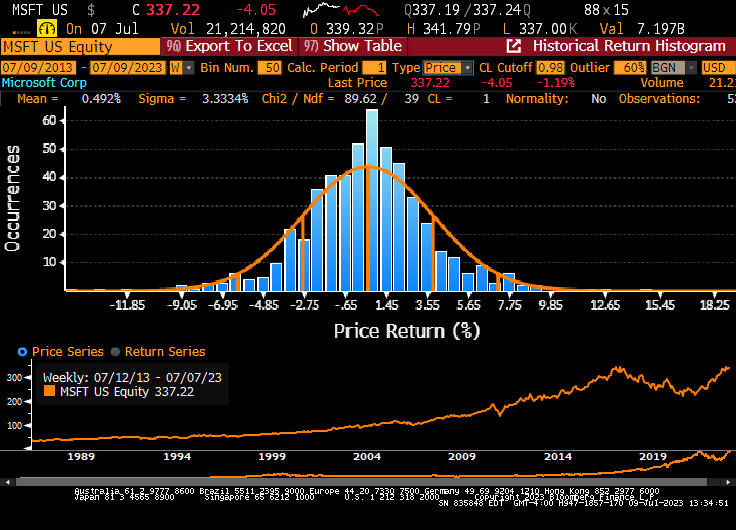

## Towards a richer model for the stock price
* To come up with a more realistic distributional model for the stock price, we now allow multiple periods in the tree
* In each period, we assume the stock price can go only up or down as before
* But by stringing many such periods back to back, we can generate very rich dynamics for the stock price over many periods
* The basic one period model is now modified to be
\begin{align}
    S_{up} &= e^{+\sigma \sqrt{\tau}} \times S_0 \\
    S_{dn} &= e^{-\sigma \sqrt{\tau}} \times S_0
\end{align}
* The one-period return is $r \equiv \pm \sigma \sqrt{\tau}$ where $\tau$ is some fraction of a year, e.g., $\tau=1/20$
* Assuming the up probability is $\pi$, a little algebra shows that
$$
    E[r] = (2\pi-1)\sigma \sqrt{\tau} \qquad\text{and}\qquad var(r) = 4\pi(1-\pi)\sigma^2\tau
$$
* How to interpret $\sigma$?
    * As $\pi \to 1/2$, the $E[r]$ becomes zero and $var(r)$ equals $\sigma^2 \tau$
    * $\sigma$ can then be interpreted as the *annual return volatility*

## Let's check what happens under the risk-neutral probabilities
* Using the risk-neutral up probability formula from before we see that
$$
     Q = \frac{e^{r_f\tau}-e^{-\sigma\sqrt{\tau}}}{e^{\sigma\sqrt{\tau}}-e^{-\sigma\sqrt{\tau}}}
$$
where we've replaced $1+r_f$ with $\exp(r_f\tau)$ and cancelled the $S_0$'s
* Since $\exp(x) \approx 1 + x$ when $x$ is small, we can approximate the above for small $\tau$ as
$$
    Q \approx \frac{r_f\tau + \sigma\sqrt{\tau}}{2 \sigma\sqrt{\tau}} = \frac{r_f\sqrt{\tau} + \sigma}{2 \sigma}
$$
* As $\tau \to 0$, the risk-neutral probability does go to 1/2 and then we can interpret $\sigma$ as the annual return volatility under the risk-neutral probabilities
* Let's now check whether our asymptotic argument is correct numerically

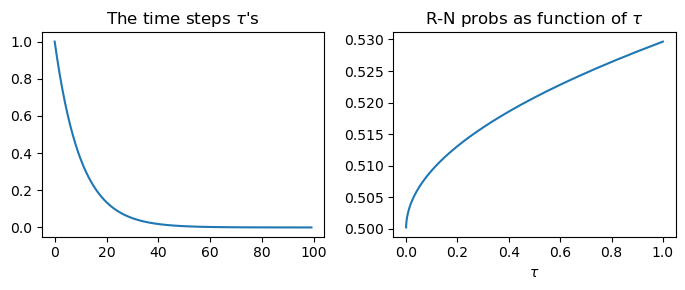

In [9]:
import matplotlib.pyplot as plt
rf, sigma = 0.02, 0.15
taus = np.exp(-np.arange(0,10,0.1)) ## get decreasing time steps

## now use a comprehension to calculate the Q's for each tau
get_q = lambda xx: (np.exp(rf*xx)-np.exp(-sigma*np.sqrt(xx)))/\
    (np.exp(sigma*np.sqrt(xx))-np.exp(-sigma*np.sqrt(xx)))
qqs = [get_q(tau) for tau in taus]
qqs = pd.Series(qqs,index=taus)

## plot output
fig, axs = plt.subplots(1,2,figsize=(7,3))
axs[0].plot(taus); axs[0].set_title('The time steps $\\tau$\'s')
qqs.plot(title='R-N probs as function of $\\tau$',ax=axs[1],xlabel='$\\tau$')
plt.tight_layout() ## fix spacing between the two plots

## An aside on Pandas
* `pandas` is a super-useful package in Python that allows you to work with time-series or panel data sets
* It gives useful tools for merging and manipulating data, as well as for plotting
* We'll see `DataFrame`s soon, but for now, let's look at the `Series` object

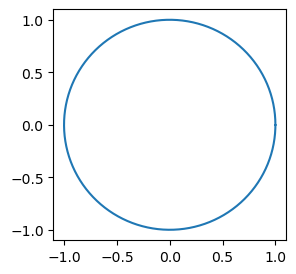

In [10]:
thetas = np.arange(0,2*np.pi,0.01)
aa = pd.Series(np.sin(thetas),index=np.cos(thetas))
aa.plot(figsize=(3,3)); ## make figure dimensions symmetric

### Now that are comfortable that our 1-step dynamics work well, let's look at at N-step tree
* The tree is *recombining* (why is this useful?) and is called the *binomial tree model*
* It generates $N+1$ outcomes at time $N$ with a wide range of prices
* We can also calculate the risk-neutral probabilities of all of those outcomes
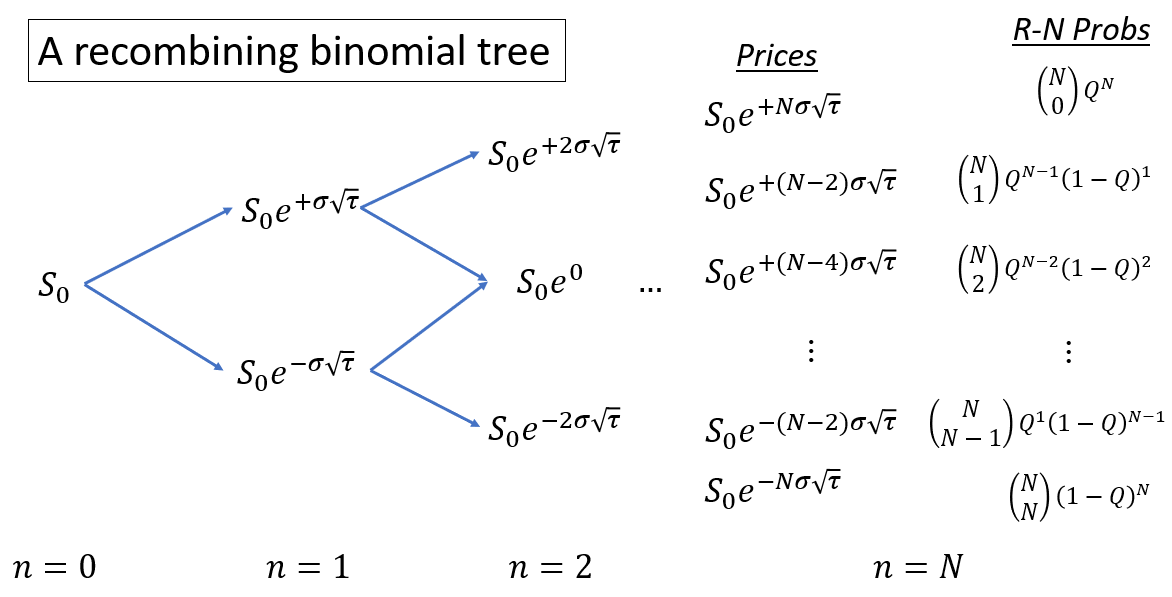

Consider a path with $N$ steps of which there are $K$ down steps and $N-K$ up steps:
* The number of such paths is
$$
\left( \begin{array}{c} N \\ K \end{array} \right)
$$
* You can also get at this by just drawing a tree and counting along the paths (see below)
* The likelihood of any one path is $Q^{N-K} (1-Q)^K$
* The overall probability of seeing a path with $N$ steps of which $K$ are down steps is
$$
\left( \begin{array}{c} N \\ K \end{array} \right) Q^{N-K} (1-Q)^K
$$

Let's now code up what the stock prices look like at the end of the tree
* And also let's get their risk-neutral probabilities

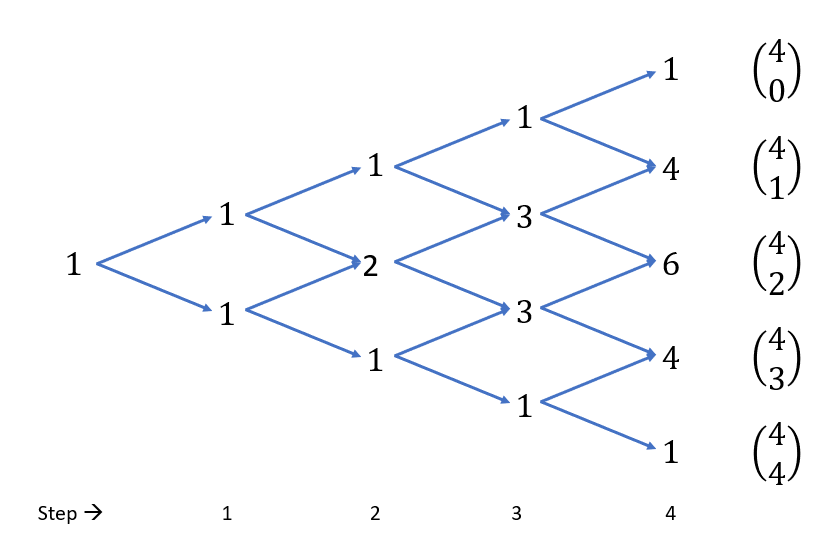

In [11]:
from math import comb
def get_Q(rf,tau,sigma):
    return (np.exp(rf*tau)-np.exp(-sigma*np.sqrt(tau)))/\
        (np.exp(sigma*np.sqrt(tau))-np.exp(-sigma*np.sqrt(tau)))

def prices_and_rnprobs(sigma,rf,TT,S0,NN,show_plot=True):
    '''
    sigma -- annual volatility, rf -- risk-free rate, TT -- option maturity,
    S0 -- initial stock price, NN -- # time steps, show_plot -- plot output
    '''
    tau = TT/NN
    SNs = [S0*np.exp((NN-ctr)*sigma*np.sqrt(tau)) for ctr in range(0,2*NN+1,2)]
    QQ = get_Q(rf,tau,sigma)
    QQs = [comb(NN,ctr)*(QQ**(NN-ctr))*((1-QQ)**ctr) for ctr in range(0,NN+1)]
    
    ## sanity check and plot if requested
    assert np.abs(sum(QQs)-1) < 1e-15
    if show_plot: plt.bar(SNs,QQs,width=1)
    
    return SNs, QQs ## we are returning prices and probabilities
    
## a note on how range works (last value is exclusive)
print(list(range(0,11,2)))

[0, 2, 4, 6, 8, 10]


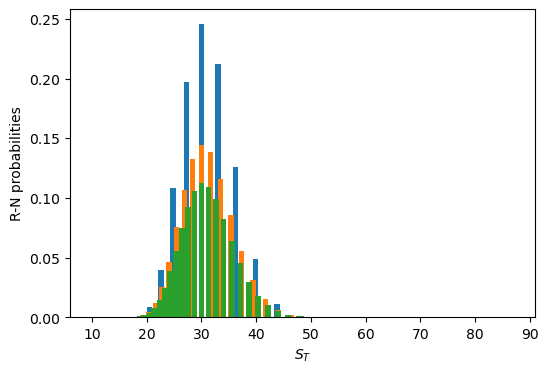

In [12]:
plt.figure(figsize=(6,4))
prices_and_rnprobs(sigma=0.15,rf=0.02,TT=1,S0=30,NN=10)
prices_and_rnprobs(sigma=0.15,rf=0.02,TT=1,S0=30,NN=30)
prices_and_rnprobs(sigma=0.15,rf=0.02,TT=1,S0=30,NN=50)
plt.xlabel('$S_T$')
plt.ylabel('R-N probabilities'); ## semi-colon means output not shown in Jupyter

## Recursive pricing of options
* For our $K=35$ strike call, we can calcualte the option payout at maturity
$$
    Payout = \max(0,S_T-K)
$$

[86.65 83.05 79.6  76.29 73.12 70.09 67.17 64.38 61.71]


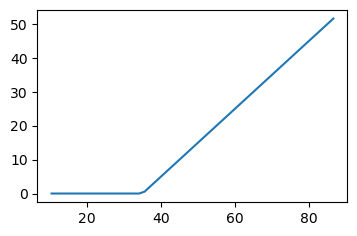

In [13]:
sigma, rf, TT, S0, NN = 0.15, 0.02, 1, 30, 50
tau, KK = TT/NN, 35
SNs, QQs = prices_and_rnprobs(sigma=sigma,rf=rf,TT=TT,S0=S0,NN=NN,show_plot=False) ## no plotting
print(np.round(SNs[:9],2))  ## note that the stock prices start high and go down
PPs = [np.maximum(0,SN-KK) for SN in SNs]
plt.figure(figsize=(4,2.5))
plt.plot(SNs,PPs);

Now we move back one step from the end of the tree
* If at step $N-1$ we know the two possible value of the option, we just use our original formula
$$
    P_{N-1,s} = \Delta \times S_{N-1,s} + X
$$
* Here the time step is $N-1$ and the state we are in is $s$
* Except it will be easier to use the R-N method (which is numerically identical!)
$$
    P_{N-1,s} = e^{-r_f \times \tau} [Q \times P_{N,s^+} + (1-Q) \times P_{N,s^-}]
$$
* The $s^+$ and $s^-$ mean the up and down stock state from state $s$
* The reason this is easier is because we don't need to know the stock price $S_{N-1,s}$ and because
$$
     Q = \frac{e^{r_f\tau}-e^{-\sigma\sqrt{\tau}}}{e^{\sigma\sqrt{\tau}}-e^{-\sigma\sqrt{\tau}}}
$$
is the same at each node in the tree

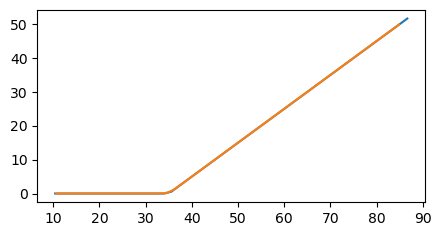

In [14]:
step = NN-1
prior_PPs, prior_SNs = PPs, SNs  ## we already calculated these earlier
curr_PPs, curr_SNs = [], []
disc = np.exp(-rf*tau)
QQ = get_Q(rf,tau,sigma)
for ii in range(0,step+1):  ## there are step+1 nodes in this time step
    PP = disc * (QQ * prior_PPs[ii] + (1-QQ) * prior_PPs[ii+1])
    ## can get stock price in current position in tree from prior stock prices
    SN = disc * (QQ * prior_SNs[ii] + (1-QQ) * prior_SNs[ii+1])
    curr_PPs.append(PP); curr_SNs.append(SN)
## show output
plt.figure(figsize=(5,2.5))
plt.plot(SNs,PPs)
plt.plot(curr_SNs,curr_PPs);

* The step $N-1$ option prices are slightly smoothed versions of the step $N$ ones

## Combining into one function

* The code above took one backward step from the final step in the tree to the one before
* At the end of the tree, we know the value of the stock from our stock model, and we know the value of the option from its contractual payout
* When we then step back from step $N$ to step $N-1$ we just use the no-arbitrage pricing to determine the value of the option or of the stock at node $s$ in step $n$ from knowing the values of the stock or option at step $n+1$ in nodes $s^+$ or $s^-$
* We are going to store each step of the tree in a dictionary

In [15]:
pp = {2:[0.5,0.75,1.1],1:[0.65,0.875],0:[0.77]}
print(pp)
print(pp[2])
print(pp[1])
print(pp[0])

{2: [0.5, 0.75, 1.1], 1: [0.65, 0.875], 0: [0.77]}
[0.5, 0.75, 1.1]
[0.65, 0.875]
[0.77]


In [26]:
def price_european_option(sigma,rf,TT,S0,KK,kind,NN):
    '''
    sigma, rr, TT, S0, KK -- the annual volatility, risk-free rate, maturity, stock price, strike
    kind -- 'call' or 'put', NN -- number of steps in the tree
    '''
    assert kind in ['call','put']
    SNs, QQs = prices_and_rnprobs(sigma=sigma,rf=rf,TT=TT,S0=S0,NN=NN,
                                  show_plot=False)
    ## store each step of tree in a dictionary
    if kind == 'call':
        all_PPs = {NN:[np.maximum(SS-KK,0) for SS in SNs]}
    else:
        all_PPs = {NN:[np.maximum(KK-SS,0) for SS in SNs]}
    all_SNs = {NN:SNs}
    
    ## price backwards from the end
    tau = TT/NN
    disc, QQ = np.exp(-rf*tau), get_Q(rf,tau,sigma)
    for ii in range(NN-1,-1,-1):
        all_PPs[ii] = []; all_SNs[ii] = []
        ## price both the option and the stock backwards through the tree
        for nn in range(0,ii+1):
            all_PPs[ii].append(disc*(QQ*all_PPs[ii+1][nn]+\
                                     (1-QQ)*all_PPs[ii+1][nn+1]))
            all_SNs[ii].append(disc*(QQ*all_SNs[ii+1][nn]+\
                                     (1-QQ)*all_SNs[ii+1][nn+1]))
        
    ## this data structure will store each successive time step
    return all_SNs, all_PPs

In [27]:
ss, pp = price_european_option(sigma,rf,TT,S0,KK,'call',NN=50)
## Note that ss and pp are dictionaries indexed by the step number in the tree
print(ss[2])
print(ss[1],pp[1])
print(ss[0],pp[0])

[31.300178128407662, 30.00000000000016, 28.75382997207867]
[30.643194086978518, 29.3703064192794] [0.6202036621468845, 0.3586479751716735]
[30.000000000000167] [0.4903088783432341]


## There is a shortcut using the risk-neutral formula
$$
    P_0 = e^{-r_f\tau} E^Q_0[P_1]
$$
* Using iterated expectations, this implies that
\begin{align}
    P_0   &= e^{-r_f\tau} E^Q_0[P_1] \nonumber \\
    \quad &= e^{-r_f\tau} E^Q_0[e^{-r_f\tau} E^Q_1[P_2]] \nonumber \\
    \quad &= e^{-2r_f\tau} E^Q_0[P_2] \nonumber
\end{align}
* And continuing this forward we get
$$
    P_0 = e^{-r_f T} E^Q_0[P_T]
$$
where $P_T$ is the value of the option prices at the final maturity of the option
* For American options (with early exercise), this does not work, but for Europeans we get the *identical* answer

In [29]:
P0 = sum([pp*qq for pp,qq in zip(PPs,QQs)])*np.exp(-rf*TT)
print(P0)

0.49030887834323333


## Tidying up
* So far, we've focused on the algorithmic and data structure parts of the problem
* Let's now work on the software engineering part
* Here we want to use a class to define an option object and to define operations that can act on this object
* In a class, the data storage parts are called *fields* and the functions that operate on objects are called *methods*
* We're now going to define a class to contain the information and methods needed to price options
    * Each class must have a method called `__init__(self,...)` which is the constructor -- this tells the class how to create itself
    * A useful helper method is `__repr__(self)` which tells the class how to display itself in a useful way (another similar method is `__str__(self)`
    * In these methods `self` refers to the particular instance of the class that is being created

In [21]:
class Option:
    
    def __init__(self,sigma,rf,TT,S0,KK):
        '''
        This is the constructor and self refers to the object instance. It must be the first argument
        passed into the constructor. The constructor is called with the information to create an Option
        object, and then the class provides operations to perform on this object.
        '''
        
        self.sigma = sigma
        self.rf = rf
        self.TT = TT
        self.S0 = S0
        self.KK = KK
        
    def __repr__(self):   ## what  information to show about self
        
        return f'sigma:{self.sigma}  ' + f'rf:{self.rf}  ' + f'TT (mat):{self.TT}  ' + \
            f'S0:{self.S0}  ' + f'KK (strike):{self.KK}\n'

    def get_Q(self,tau):  ## object already knows rf and sigma
        return (np.exp(self.rf*tau)-np.exp(-self.sigma*np.sqrt(tau))) / \
            (np.exp(self.sigma*np.sqrt(tau))-np.exp(-self.sigma*np.sqrt(tau)))

In [22]:
opt = Option(sigma,rf,TT,S0,KK)
print(opt)
print('RN prob =',opt.get_Q(1/20))

sigma:0.15  rf:0.02  TT (mat):1  S0:30  KK (strike):35

RN prob = 0.5065273108926767


We'd like to add a few more methods to this class:
* `prices_and_rnprobs_at_step` -- this should return stock prices and risk-neutral plobabilities at a given step in the tree
* `plot_rn_price_dist_at_step` -- plot the risk-neutral price distribution
* `price_european_option_with_tree` -- the binomial tree code
* etc.

When defining a class, it is good practice to write all the code in a separate `.py` file and then import it into Jupyter (or some other IDE)
* Jupyter is great for making course content (like this)
* It is okay for writing the high-level driver routines for projects
* It is very bad to write your function and class definitions in Jupyter
    * The Jupyter debugger isn't great either

* To import files into Jupyter or Spyder or some other IDE, you would typically set your system's `PYTHONPATH` variables, for example:

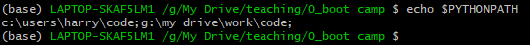
* In the next example, we'll do this "manually"
* But first we need to tell Jupyter to update the referenced *.py* files when they are changed

In [23]:
## tell Jupyter to reload all imports when it reruns any cell
%load_ext autoreload
%autoreload 2

In [24]:
import os
os.chdir('g:/My Drive/teaching/1_boot camp python')
import options as opts ## imports the options.py file in the above directory
opt = opts.Option(sigma,rf,TT,S0,KK) ## the class definition is inside opts
print(opt)
print('RN prob =',opt.get_Q(1/20))

sigma:0.15  rf:0.02  TT (mat):1  S0:30  KK (strike):35

RN prob = 0.5065273108926767


[30.000000000000167] [0.4903088783432341]


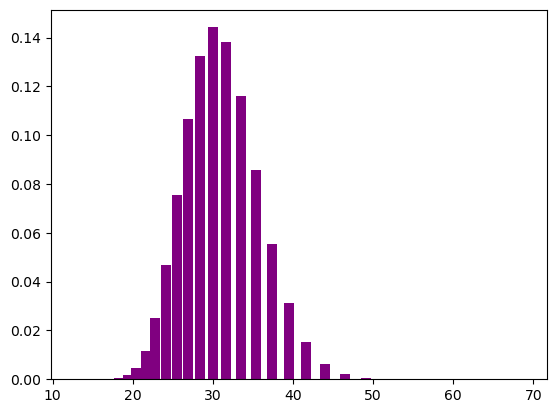

In [25]:
opt.plot_rn_price_dist_at_step(nn=30,NN=30)
ss,pp=opt.price_european_option_with_tree(50,'call')
print(ss[0],pp[0])

## Summarizing
* Binomial trees are intuitively easier to grasp
* The get arbitrarily close to the "correct" Black-Scholes-Merton price (next time)
* Classes are an excellent way to organize your code
* Better not to write large amounts of code in Jupyter
    * Write code in stand-alone files and import them into your Jupyter notebooks
    * The Jupyter notebooks are the *driver* routines not the main code base